In [0]:
pip install openpyxl

Python interpreter will be restarted.
Collecting openpyxl
 Using cached openpyxl-3.0.10-py2.py3-none-any.whl (242 kB)
Collecting et-xmlfile
 Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Installing collected packages: et-xmlfile, openpyxl
Successfully installed et-xmlfile-1.1.0 openpyxl-3.0.10
Python interpreter will be restarted.

In [0]:
pip install pickle-mixin

Python interpreter will be restarted.
Collecting pickle-mixin
 Downloading pickle-mixin-1.0.2.tar.gz (5.1 kB)
Building wheels for collected packages: pickle-mixin
 Building wheel for pickle-mixin (setup.py): started
 Building wheel for pickle-mixin (setup.py): finished with status 'done'
 Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5998 sha256=d5d5cd5b61a004ef763ceb734f2289a4a9add4356ea1e00ee8ec1a5480e57947
 Stored in directory: /root/.cache/pip/wheels/2a/a4/6c/83bfbc3b94f1bb43d634b07a6a893fd437a45c58b29aea5142
Successfully built pickle-mixin
Installing collected packages: pickle-mixin
Successfully installed pickle-mixin-1.0.2
Python interpreter will be restarted.

In [0]:
pip install textblob

Python interpreter will be restarted.
Collecting textblob
 Downloading textblob-0.17.1-py2.py3-none-any.whl (636 kB)
Requirement already satisfied: nltk>=3.1 in /databricks/python3/lib/python3.8/site-packages (from textblob) (3.6.1)
Requirement already satisfied: joblib in /databricks/python3/lib/python3.8/site-packages (from nltk>=3.1->textblob) (1.0.1)
Requirement already satisfied: click in /databricks/python3/lib/python3.8/site-packages (from nltk>=3.1->textblob) (7.1.2)
Requirement already satisfied: regex in /databricks/python3/lib/python3.8/site-packages (from nltk>=3.1->textblob) (2021.4.4)
Requirement already satisfied: tqdm in /databricks/python3/lib/python3.8/site-packages (from nltk>=3.1->textblob) (4.59.0)
Installing collected packages: textblob
Successfully installed textblob-0.17.1
Python interpreter will be restarted.

In [0]:
pip install fuzzywuzzy

Python interpreter will be restarted.
Collecting fuzzywuzzy
 Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)
Installing collected packages: fuzzywuzzy
Successfully installed fuzzywuzzy-0.18.0
Python interpreter will be restarted.

In [0]:
pip install pickle-mixin

Python interpreter will be restarted.
Requirement already satisfied: pickle-mixin in /local_disk0/.ephemeral_nfs/envs/pythonEnv-6da82a80-7aac-48f3-90e3-b458e870c11a/lib/python3.8/site-packages (1.0.2)
Python interpreter will be restarted.

In [0]:
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
import string
import pandas as pd
import numpy as np
import re
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score ### understand why these packages imported already but still need to import their seed element
from scipy.spatial.distance import cosine
from scipy import spatial

from fuzzywuzzy import fuzz
from xgboost import XGBClassifier
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Package wordnet is already up-to-date!
/local_disk0/.ephemeral_nfs/envs/pythonEnv-6da82a80-7aac-48f3-90e3-b458e870c11a/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
 warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')

In [0]:
file_path = "/dbfs/FileStore/shared_uploads/xiaomeng.fan@aia.com/"

df_raw = pd.read_excel(file_path+"Copy_of_Jun_2022_Training_Data___ML.xlsx")[['prediction', 'question', 'confidence_level', 'can MAIA answer?', 'POS / Non-POS', 'is_pos_content']].dropna()
df_raw.columns = ['response', 'question', 'confidence', 'tag', 'Department', 'is_pos_content']
df_raw_pos = df_raw[df_raw['Department']=='POS']

In [0]:
stopwords_query_result = spark.sql("""
select stopword from ops_pos_wrk.aosda_maia_stopwords
""")

df_stopwords = stopwords_query_result.toPandas()
sw_list = df_stopwords['stopword'].tolist()

In [0]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.extend(sw_list)

In [0]:
## define function to split and process MAIA intent respond i.e.: 'POS_Premium_Infomation'
def text_preprocessing1(val):
  text_orig = val.lower()
  
  text_punc = " ".join(word.strip(string.punctuation) for word in text_orig.split('_')) ### 1 with [] 1 without, any difference?
  text_punc_sw = " ".join([word for word in nltk.word_tokenize(text_punc) if word not in stopword_list])### do this sequence reasonable? token before remove "_"?
    
  return text_punc_sw

In [0]:
def text_preprocessing2(val):
  text_orig = val.lower()
  
  text_pol_clean = re.sub(r'\w{1}\d{9}','',text_orig)
  text_pol_nric_clean = re.sub(r'[sfgtm]\d{7}[a-z]','',text_pol_clean) ## Stage 1 replace with uniform name, stage 2 remove, why? difference?
 # chat_pol_nric_posterm_clean = re.sub(pos_terms_list,'AIAPOSTerm',chat_pol_nric_clean)
 # chat_pol_nric_posterm_dpmt_clean = re.sub(r'u&i|cnc|clm|pos','OpsDpmt',chat_pol_nric_posterm_clean)  ## Why comment out?
  text_token_pol_nric_clean = " ".join([word for word in nltk.word_tokenize(text_pol_nric_clean) if word not in stopword_list])### do this sequence reasonable? token before remove "_"?
  text_token_punc_pol_nric_clean = " ".join(word.strip(string.punctuation) for word in text_token_pol_nric_clean.split())
  
  
  ###define emoji RE pattern
  emoji_pattern = re.compile("["
           u"\U0001F600-\U0001F64F"  # emoticons
           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
           u"\U0001F680-\U0001F6FF"  # transport & map symbols
           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
  text_pol_nric_emo_clean = emoji_pattern.sub(r'',text_pol_nric_clean)
  
  lemmatizer = WordNetLemmatizer()
  text_pol_nric_emo_lem_clean = ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text_pol_nric_emo_clean)])
  
  return text_pol_nric_emo_lem_clean


In [0]:
df_raw_pos['response_c'] = df_raw_pos['response'].apply(text_preprocessing1)
df_raw_pos['question_c'] = df_raw_pos['question'].apply(text_preprocessing2)

<command-2701151936558443>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df_raw_pos['response_c'] = df_raw_pos['response'].apply(text_preprocessing1)
<command-2701151936558443>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df_raw_pos['question_c'] = df_raw_pos['question'].apply(text_preprocessing2)

In [0]:
display(df_raw_pos)
print("POS Training Data Size : " + str(df_raw_pos.shape))
df_raw_pos['tag'].value_counts()

response,question,confidence,tag,Department,is_pos_content,response_c,question_c
Refund,Q514050177 dividend payment,0.32420958280563356,No,POS,1,refund,dividend payment
Coupon_Payment_Details,L533278532 coupon,0.7661356449127197,Yes,POS,1,coupon payment details,coupon
Withdrawal_Procedures,Q514050177 dividend withdrawal,0.9163254261016847,Yes,POS,1,withdrawal procedures,dividend withdrawal
Premium_Holiday,premium holiday,0.9836024284362794,Yes,POS,1,premium holiday,premium holiday
Reinstatement_Procedures_Rules,H235938743 reinstatement,0.5169537782669067,Yes,POS,1,reinstatement procedures rules,reinstatement
NB_Instant_COL,"H224151117 - client signed and sent in a counteroffer, why counter offer closed?",0.6671443939208985,No,POS,0,nb instant col,"- client signed and sent in a counteroffer , why counter offer closed ?"
POS_LPA_POA,"Q512134642 - Power of Attorney (LPA) form 1 done, can the donee can sign on all policy changes from now on?",0.9699352741241456,Yes,POS,1,pos lpa poa,"- power of attorney ( lpa ) form 1 done , can the donee can sign on all policy change from now on ?"
Marketing_SFT,"good afternoon, may i check if i can add in rider for an older term ""AIA Secure Term"", lets say Critical Illness rider",0.7572103023529053,No,POS,0,marketing sft,"good afternoon , may i check if i can add in rider for an older term `` aia secure term '' , let say critical illness rider"
Add_Rider,add in rider,0.8875681400299074,Yes,POS,1,add rider,add in rider
Freelook,L548630136 - cancel policy with free look,0.7700406074523927,Yes,POS,1,freelook,- cancel policy with free look


POS Training Data Size : (6739, 8)
Out[8]: Yes 5190
No 1549
Name: tag, dtype: int64

Classification Modeling

In [0]:
## Ratio of similarity

df_compare = df_raw_pos.copy() ### why not direct assign

df_compare['Ratio'] = df_compare.apply(lambda x: fuzz.ratio(x.response_c, x.question_c), axis=1)*0.01

df_compare['Ratio_combine'] = df_compare['Ratio']*df_compare['confidence'] ## this ratio is not used in the prediction

In [0]:
df_compare['response_question'] = df_compare.apply(lambda x : x['response_c'] + ' ' + x['question_c'], axis = 1)

clf = TfidfVectorizer(ngram_range=(1,1)) ### ngram define the min,max ngram token considered, (1,1) only unigram, (1,2) both uni/bigram, (2,2) only bigram
clf.fit(df_compare['response_question']) ### 1st fit the model with the combined qns and respond
tfidf_a = clf.transform(df_compare['response_c']).todense()## transform the original data with the fitted model
tfidf_b = clf.transform(df_compare['question_c']).todense()

row_similarities = [1 - spatial.distance.cosine(tfidf_a[x], tfidf_b[x]) for x in range(len(tfidf_a))] ### why the result show 1 as the same, but the 1-cosine(x) should be 0 when both are the same

df_compare['row_similarities'] = row_similarities

/databricks/python/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
 dist = 1.0 - uv / np.sqrt(uu * vv)

In [0]:
df_compare.to_pickle(file_path+"stg2_clean.pkl")

In [0]:
display(df_compare)

response,question,confidence,tag,Department,is_pos_content,response_c,question_c,Ratio,Ratio_combine,response_question,row_similarities
Refund,Q514050177 dividend payment,0.32420958280563356,No,POS,1,refund,dividend payment,0.27,0.08753658735752107,refund dividend payment,0.0
Coupon_Payment_Details,L533278532 coupon,0.7661356449127197,Yes,POS,1,coupon payment details,coupon,0.43,0.32943832731246947,coupon payment details coupon,0.5957817822877031
Withdrawal_Procedures,Q514050177 dividend withdrawal,0.9163254261016847,Yes,POS,1,withdrawal procedures,dividend withdrawal,0.5,0.45816271305084233,withdrawal procedures dividend withdrawal,0.44429209974432626
Premium_Holiday,premium holiday,0.9836024284362794,Yes,POS,1,premium holiday,premium holiday,1.0,0.9836024284362794,premium holiday premium holiday,1.0
Reinstatement_Procedures_Rules,H235938743 reinstatement,0.5169537782669067,Yes,POS,1,reinstatement procedures rules,reinstatement,0.6,0.310172266960144,reinstatement procedures rules reinstatement,0.5433500159506385
NB_Instant_COL,"H224151117 - client signed and sent in a counteroffer, why counter offer closed?",0.6671443939208985,No,POS,0,nb instant col,"- client signed and sent in a counteroffer , why counter offer closed ?",0.21,0.14010032272338868,"nb instant col - client signed and sent in a counteroffer , why counter offer closed ?",0.0
POS_LPA_POA,"Q512134642 - Power of Attorney (LPA) form 1 done, can the donee can sign on all policy changes from now on?",0.9699352741241456,Yes,POS,1,pos lpa poa,"- power of attorney ( lpa ) form 1 done , can the donee can sign on all policy change from now on ?",0.18,0.1745883493423462,"pos lpa poa - power of attorney ( lpa ) form 1 done , can the donee can sign on all policy change from now on ?",0.24773678864776605
Marketing_SFT,"good afternoon, may i check if i can add in rider for an older term ""AIA Secure Term"", lets say Critical Illness rider",0.7572103023529053,No,POS,0,marketing sft,"good afternoon , may i check if i can add in rider for an older term `` aia secure term '' , let say critical illness rider",0.12,0.09086523628234863,"marketing sft good afternoon , may i check if i can add in rider for an older term `` aia secure term '' , let say critical illness rider",0.0
Add_Rider,add in rider,0.8875681400299074,Yes,POS,1,add rider,add in rider,0.86,0.7633086004257204,add rider add in rider,0.8311766594166912
Freelook,L548630136 - cancel policy with free look,0.7700406074523927,Yes,POS,1,freelook,- cancel policy with free look,0.42,0.3234170551300049,freelook - cancel policy with free look,0.0


In [0]:
X, Y = df_compare[df_compare.columns.difference(['question', 'response_c', 'question_c', 'response_question', 'response', 'tag', 'Department'])], df_compare[['tag']] ## why have to use difference?

In [0]:
print(df_compare.columns.difference(['question', 'response_c', 'question_c', 'response_question', 'response', 'tag', 'Department']))

Index(['Ratio', 'Ratio_combine', 'confidence', 'is_pos_content',
 'row_similarities'],
 dtype='object')

In [0]:
seed = 8
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [0]:
model_stg2 = XGBClassifier(eval_metric = 'logloss', random_state=137)
model_stg2.fit(X_train, y_train)

/databricks/python/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
 warnings.warn(label_encoder_deprecation_msg, UserWarning)
/databricks/python/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(*args, **kwargs)
Out[16]: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
 eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
 interaction_constraints='', learning_rate=0.300000012,
 max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
 monotone_constraints='()', n_estimators=100, n_jobs=8,
 num_parallel_tree=1, predictor='auto', random_state=137,
 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
 tree_method='exact', validate_parameters=1, verbosity=None)

In [0]:
display(X_train)

Ratio,Ratio_combine,confidence,is_pos_content,row_similarities
0.44,0.15278809452056885,0.3472456693649292,0,0.0
0.21,0.19501364564895632,0.9286364078521729,0,0.0
0.21,0.10072104692459107,0.47962403297424316,1,0.0
0.12,0.11078799247741698,0.9232332706451416,1,0.16159473569728866
0.68,0.27501222705841066,0.4044297456741333,1,0.3761626197000596
0.11,0.06624586391448975,0.6022351264953614,0,0.049605762505981144
0.31,0.24991727828979493,0.8061847686767578,1,0.0
0.32,0.24738746643066406,0.7730858325958252,1,0.1396056827459995
0.16,0.13302568817138674,0.8314105510711671,1,0.0
0.26,0.21365602207183837,0.8217539310455322,0,0.0


In [0]:
Save_Stg2_Model_Name = '/dbfs/FileStore/shared_uploads/xiaomeng.fan@aia.com/POS_MAIA_Answer_Examination_Model.sav'
pickle.dump(model_stg2,open(Save_Stg2_Model_Name,'wb'))

Out[15]:

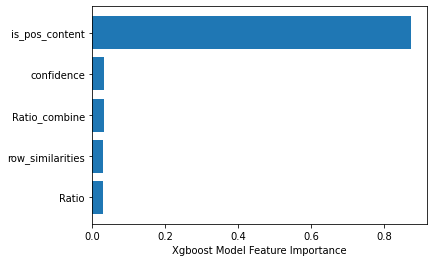

Text(0.5, 0, 'Xgboost Model Feature Importance')

In [0]:
### Check feature importance
sorted_idx = model_stg2.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_stg2.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Model Feature Importance")

In [0]:
y_pred = model_stg2.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: {0:.2f}%".format(accuracy*100))

Accuracy: 88.58%

[[201 114]
 [ 40 993]]
Out[23]:

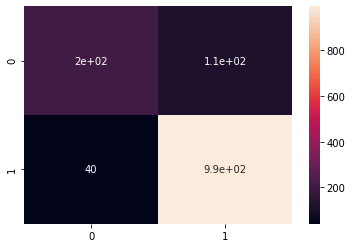

<AxesSubplot:>

In [0]:
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [0]:
print(classification_report(y_test,y_pred))

precision recall f1-score support

 No 0.83 0.64 0.72 315
 Yes 0.90 0.96 0.93 1033

 accuracy 0.89 1348
 macro avg 0.87 0.80 0.83 1348
weighted avg 0.88 0.89 0.88 1348

In [0]:
array = [34, 66, 12]
print("A = {0}, B = {1}, C = {2}".format(*array))

d = {
'hats' : 122,
'mats' : 42
}

"Sam had {hats} hats and {mats} mats".format(**d)


In [0]:
(lambda x: x.upper())('test')

df['Gender'] = df['Status'].map(lambda x: 'Male' if x=='father' or x=='son' else 'Female')

Out[13]: 'TEST'

In [0]:
sin_id_pattern = re.compile(r'[sfgtm]\d{7}[a-z]')

test = sin_id_pattern.sub('bingo', 'my fin is g1352640r and my sprid is s9056517f')
print(test)

my fin is bingo and my sprid is bingo